# This notebook plots time series of global mean PW, precipitation, and their ratio
## Figures produced in the MCSMIP paper:
- Figure 3
## The data is produced by:
- /src/avg_global_env_map_timeseries.py
- /src/avg_global_rain_timeseries.py

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import copy
import seaborn as sns
%matplotlib inline

In [2]:
# PHASE = 'Summer'
PHASE = 'Winter'

env_varname = 'intqv'

# PF land fraction threshold to separate land vs. ocean MCS
# land_frac_thresh = 0.7
# ocean_frac_thresh = 0.1

if PHASE == 'Summer':
    block_times = pd.to_datetime(['2016-08-01T00', '2016-08-10T00'])
if PHASE == 'Winter':
    block_times = pd.to_datetime(['2020-01-20T00', '2020-02-01T00'])

rootdir = f'/pscratch/sd/f/feng045/DYAMOND/{PHASE}/'

if PHASE == 'Summer':
    name_map = {
        'obs': 'OBS',
        'obsv7': 'OBSv7',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'FV3',
        'm12': 'SCREAMv1',
    }

if PHASE == 'Winter':
    name_map = {
        'obs': 'OBS',
        'obsv7': 'OBSv7',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        # 'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'GRIST',
        'm8': 'SCREAM',
        'm9': 'XSHiELD',
        'm10': 'GEOS',
        'm11': 'ICON',
        'm12': 'SCREAMv1',
    }

# Environmental files
ssmi_timeseries = f'{rootdir}OBS/envs/{PHASE}_HOAPS_intqv_timeseries.nc'
envfiles_timeseries = {key:f'{rootdir}{value}/envs/{PHASE}_{value}_{env_varname}_timeseries.nc' for key,value in name_map.items()}
rainfiles_timeseries = {key:f'{rootdir}{value}/envs/{PHASE}_{value}_rain_timeseries.nc' for key,value in name_map.items()}

figdir = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/MCSMIP/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/MCSMIP/


## Check if input files exist

In [3]:
print(f'{ssmi_timeseries}: {os.path.isfile(ssmi_timeseries)}')

/pscratch/sd/f/feng045/DYAMOND/Summer/OBS/envs/Summer_HOAPS_intqv_timeseries.nc: True


In [4]:
for key, value in envfiles_timeseries.items():
    print(f'{value}: {os.path.isfile(value)}')
    
for key, value in rainfiles_timeseries.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/Summer/OBS/envs/Summer_OBS_intqv_timeseries.nc: True
/pscratch/sd/f/feng045/DYAMOND/Summer/OBSv7/envs/Summer_OBSv7_intqv_timeseries.nc: True
/pscratch/sd/f/feng045/DYAMOND/Summer/ARPEGE/envs/Summer_ARPEGE_intqv_timeseries.nc: True
/pscratch/sd/f/feng045/DYAMOND/Summer/IFS/envs/Summer_IFS_intqv_timeseries.nc: True
/pscratch/sd/f/feng045/DYAMOND/Summer/MPAS/envs/Summer_MPAS_intqv_timeseries.nc: True
/pscratch/sd/f/feng045/DYAMOND/Summer/NICAM/envs/Summer_NICAM_intqv_timeseries.nc: True
/pscratch/sd/f/feng045/DYAMOND/Summer/SAM/envs/Summer_SAM_intqv_timeseries.nc: True
/pscratch/sd/f/feng045/DYAMOND/Summer/UM/envs/Summer_UM_intqv_timeseries.nc: True
/pscratch/sd/f/feng045/DYAMOND/Summer/FV3/envs/Summer_FV3_intqv_timeseries.nc: True
/pscratch/sd/f/feng045/DYAMOND/Summer/SCREAMv1/envs/Summer_SCREAMv1_intqv_timeseries.nc: True
/pscratch/sd/f/feng045/DYAMOND/Summer/OBS/envs/Summer_OBS_rain_timeseries.nc: True
/pscratch/sd/f/feng045/DYAMOND/Summer/OBSv7/envs/Summ

In [5]:
# Read SSMI data
dss = xr.open_dataset(ssmi_timeseries)
dss

<xarray.Dataset>
Dimensions:  (time: 61)
Coordinates:
  * time     (time) datetime64[ns] 2016-08-01 2016-08-02 ... 2016-09-30
Data variables:
    intqv    (time) float32 ...
Attributes:
    title:       Mean intqv time series from HOAPS
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    lon_bounds:  [-180  180]
    lat_bounds:  [-15  30]
    created_on:  Thu May 30 11:49:41 2024

In [6]:
# Read all data in Xarray Dataset
dse = xr.open_mfdataset(list(envfiles_timeseries.values()), concat_dim='source', combine='nested')
# Assign new coordinate 'source' using names
dse['source'] = list(name_map.keys())
time_env = dse.time
lon_bounds = dse.attrs['lon_bounds']
lat_bounds = dse.attrs['lat_bounds']
dse

/global/common/software/m1867/python/py310/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


<xarray.Dataset>
Dimensions:      (time: 961, source: 10)
Coordinates:
  * time         (time) datetime64[ns] 2016-08-01 ... 2016-09-10
  * source       (source) <U5 'obs' 'obsv7' 'm1' 'm2' ... 'm5' 'm6' 'm7' 'm12'
Data variables:
    intqv        (source, time) float32 dask.array<chunksize=(1, 961), meta=np.ndarray>
    intqv_ocean  (source, time) float32 dask.array<chunksize=(1, 961), meta=np.ndarray>
Attributes:
    title:       Mean intqv time series
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    lon_bounds:  [-180  180]
    lat_bounds:  [-15  30]
    created_on:  Thu May 30 15:23:05 2024

In [7]:
# Read all data in Xarray Dataset
dsr = xr.open_mfdataset(list(rainfiles_timeseries.values()), concat_dim='source', combine='nested')
# Assign new coordinate 'source' using names
dsr['source'] = list(name_map.keys())
time_rain = dsr.time
dsr

/global/common/software/m1867/python/py310/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


<xarray.Dataset>
Dimensions:                 (time: 984, source: 10)
Coordinates:
  * time                    (time) datetime64[ns] 2016-08-01 ... 2016-09-10T2...
  * source                  (source) <U5 'obs' 'obsv7' 'm1' ... 'm6' 'm7' 'm12'
Data variables:
    precipitation           (source, time) float64 dask.array<chunksize=(1, 959), meta=np.ndarray>
    precipitation_ocean     (source, time) float64 dask.array<chunksize=(1, 959), meta=np.ndarray>
    mcs_precipitation       (source, time) float64 dask.array<chunksize=(1, 959), meta=np.ndarray>
    mcs_precipitation_frac  (source, time) float64 dask.array<chunksize=(1, 959), meta=np.ndarray>
    mcs_cloud_frac          (source, time) float64 dask.array<chunksize=(1, 959), meta=np.ndarray>
    ccs_cloud_frac          (source, time) float64 dask.array<chunksize=(1, 959), meta=np.ndarray>
Attributes:
    title:       Mean precipitation time series
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    lon_bounds:  [-180  180]
    lat_bounds:  [-15  30]
    tracker:     PyFLEXTRKR
    created_on:  Thu May 30 15:33:00 2024

(0.05, 0.3)

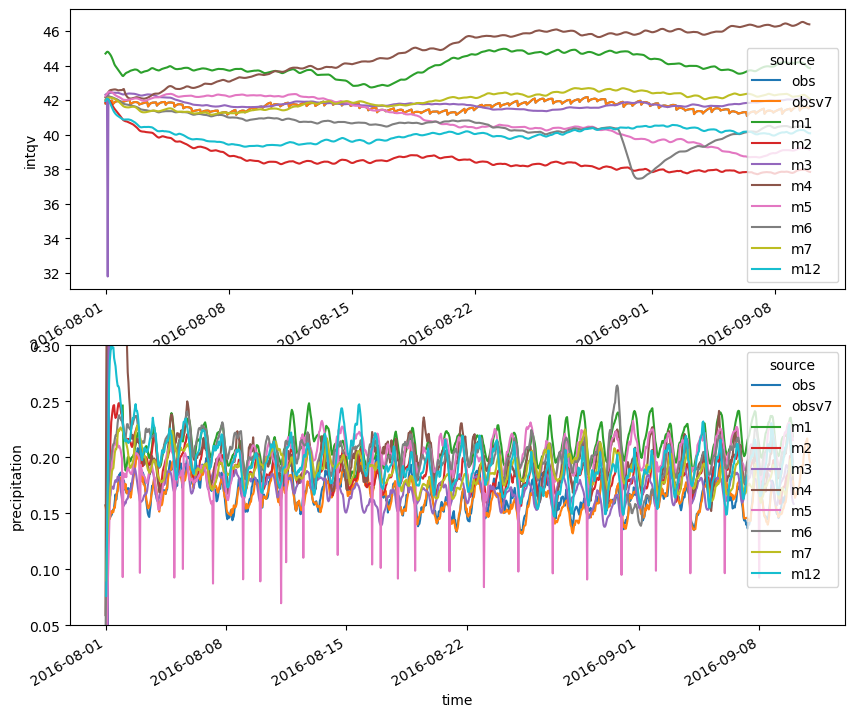

In [8]:
fig, axes = plt.subplots(2, 1, figsize=[10,8], dpi=100)
ax0 = axes[0]
xr.plot.line(dse.intqv, x='time', ax=ax0)
ax1 = axes[1]
xr.plot.line(dsr.precipitation, x='time', ax=ax1)
ax1.set_ylim(0.05, 0.3)

## Do 24-hour running mean to remove the diurnal cycle

In [9]:
window_size = 24  # 24-hour rolling window
dse_s = dse.rolling(time=window_size, min_periods=1, center=True).mean(keep_attrs=True)  # Set center=True for centered rolling mean
dsr_s = dsr.rolling(time=window_size, min_periods=1, center=True).mean(keep_attrs=True)  # Set center=True for centered rolling mean
dse_s

<xarray.Dataset>
Dimensions:      (time: 961, source: 10)
Coordinates:
  * time         (time) datetime64[ns] 2016-08-01 ... 2016-09-10
  * source       (source) <U5 'obs' 'obsv7' 'm1' 'm2' ... 'm5' 'm6' 'm7' 'm12'
Data variables:
    intqv        (source, time) float32 dask.array<chunksize=(1, 960), meta=np.ndarray>
    intqv_ocean  (source, time) float32 dask.array<chunksize=(1, 960), meta=np.ndarray>
Attributes:
    title:       Mean intqv time series
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    lon_bounds:  [-180  180]
    lat_bounds:  [-15  30]
    created_on:  Thu May 30 15:23:05 2024

In [10]:
# Find the common times among the three DataSets
common_times = (np.intersect1d(dse_s.time, dsr_s.time))
# Subset each DataSet to the common times
dse_s_com = dse_s.sel(time=common_times)
dsr_s_com = dsr_s.sel(time=common_times)
# Combine the DataSets
ds = xr.merge([dse_s_com, dsr_s_com], combine_attrs='drop_conflicts')
ds

<xarray.Dataset>
Dimensions:                 (time: 961, source: 10)
Coordinates:
  * time                    (time) datetime64[ns] 2016-08-01 ... 2016-09-10
  * source                  (source) <U5 'obs' 'obsv7' 'm1' ... 'm6' 'm7' 'm12'
Data variables:
    intqv                   (source, time) float32 dask.array<chunksize=(1, 960), meta=np.ndarray>
    intqv_ocean             (source, time) float32 dask.array<chunksize=(1, 960), meta=np.ndarray>
    precipitation           (source, time) float64 dask.array<chunksize=(1, 492), meta=np.ndarray>
    precipitation_ocean     (source, time) float64 dask.array<chunksize=(1, 492), meta=np.ndarray>
    mcs_precipitation       (source, time) float64 dask.array<chunksize=(1, 492), meta=np.ndarray>
    mcs_precipitation_frac  (source, time) float64 dask.array<chunksize=(1, 492), meta=np.ndarray>
    mcs_cloud_frac          (source, time) float64 dask.array<chunksize=(1, 492), meta=np.ndarray>
    ccs_cloud_frac          (source, time) float64 dask.array<chunksize=(1, 492), meta=np.ndarray>
Attributes:
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    lon_bounds:  [-180  180]
    lat_bounds:  [-15  30]
    tracker:     PyFLEXTRKR

## Replace ocean PW for source 'obsv7' with SSMI

In [11]:
# Interpolate SSMI DataSet to the hourly time resolution
dss_interp = dss.interp(time=ds.time)
pwv_ssmi = dss_interp.intqv
dss_interp

<xarray.Dataset>
Dimensions:  (time: 961)
Coordinates:
  * time     (time) datetime64[ns] 2016-08-01 2016-08-01T01:00:00 ... 2016-09-10
Data variables:
    intqv    (time) float64 44.61 44.61 44.6 44.59 ... 44.34 44.35 44.36 44.37
Attributes:
    title:       Mean intqv time series from HOAPS
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    lon_bounds:  [-180  180]
    lat_bounds:  [-15  30]
    created_on:  Thu May 30 11:49:41 2024

In [12]:
# pwv_ssmi.plot(color='b', label='SSMI')
# ds.intqv_ocean.sel(source='obs').plot(color='r', label='ERA5')
# ds.intqv_ocean.sel(source='obsv7').plot(color='yellow', ls='--', label='ERA5')
# plt.legend()

In [13]:
# Replace values for source 'obsv7' with pwv_ssmi
ds.intqv_ocean.loc[{'source': 'obsv7'}] = pwv_ssmi

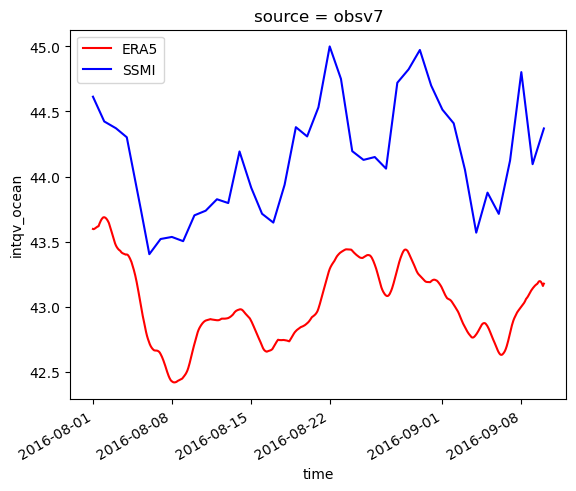

In [14]:
ds.intqv_ocean.sel(source='obs').plot(color='r', label='ERA5')
ds.intqv_ocean.sel(source='obsv7').plot(color='b', label='SSMI')
plt.legend()

In [15]:
ds.precipitation.attrs

{}

In [16]:
# Compute ratio of precipitation / PW
# units: (mm h^-1) / (kg m^-2) = 1e-3 m^3 kg^-1 h^-1
# ratio x density of water / 1e3 = 1e3 kg m^-3 * 1e-3 m^3 kg^-1 h^-1 / 1e3 = h^-1
pcp_pwv = 1e-3 * ds.precipitation / ds.intqv

pcp_pwv_ocean = 1e-3 * ds.precipitation_ocean / ds.intqv_ocean

(0.06, 0.15)

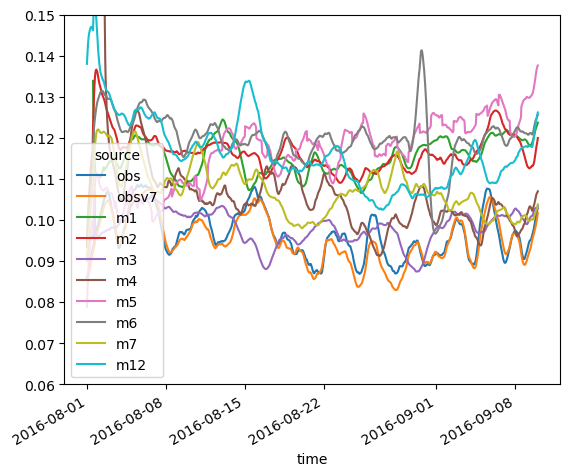

In [17]:
(24 * ds.precipitation / ds.intqv).plot.line(x='time')
plt.ylim(0.06,0.15)

(2.5e-06, 6e-06)

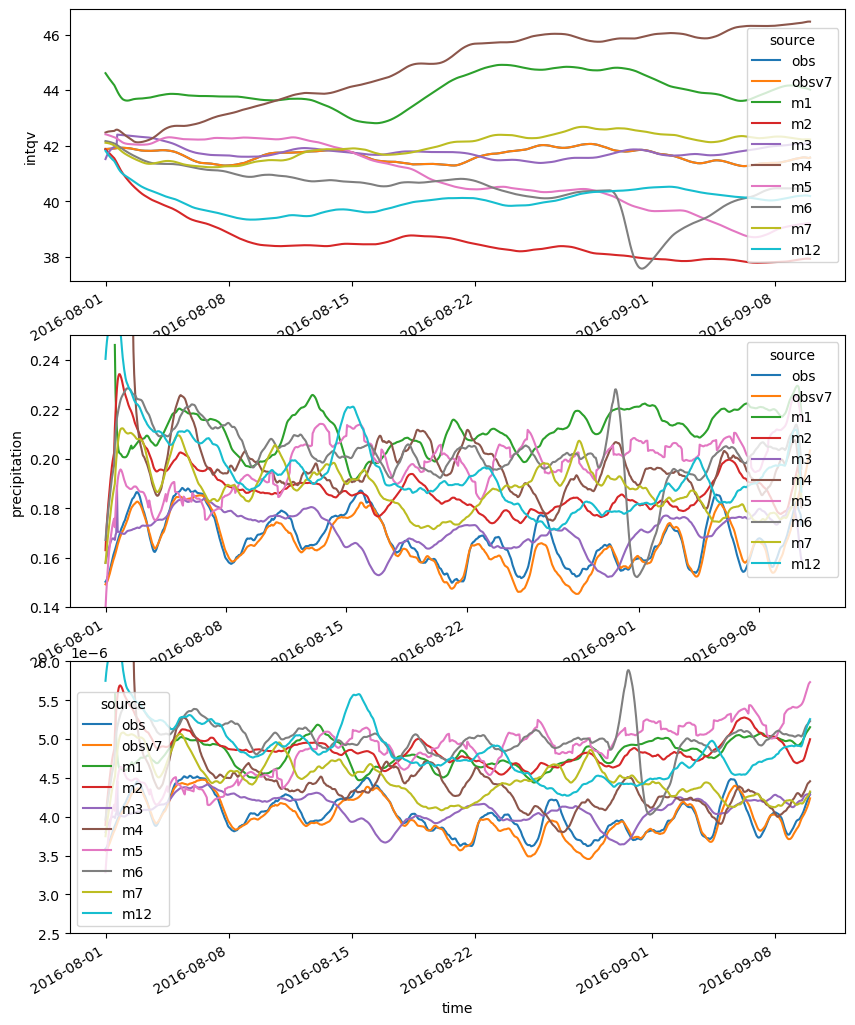

In [18]:
fig, axes = plt.subplots(3, 1, figsize=[10,12], dpi=100)
ax0 = axes[0]
xr.plot.line(dse_s.intqv, x='time', ax=ax0)
ax1 = axes[1]
xr.plot.line(dsr_s.precipitation, x='time', ax=ax1)
ax1.set_ylim(0.14, 0.25)
ax2 = axes[2]
xr.plot.line(pcp_pwv, x='time', ax=ax2)
ax2.set_ylim(0.25e-5, 0.6e-5)

(2.5e-06, 6e-06)

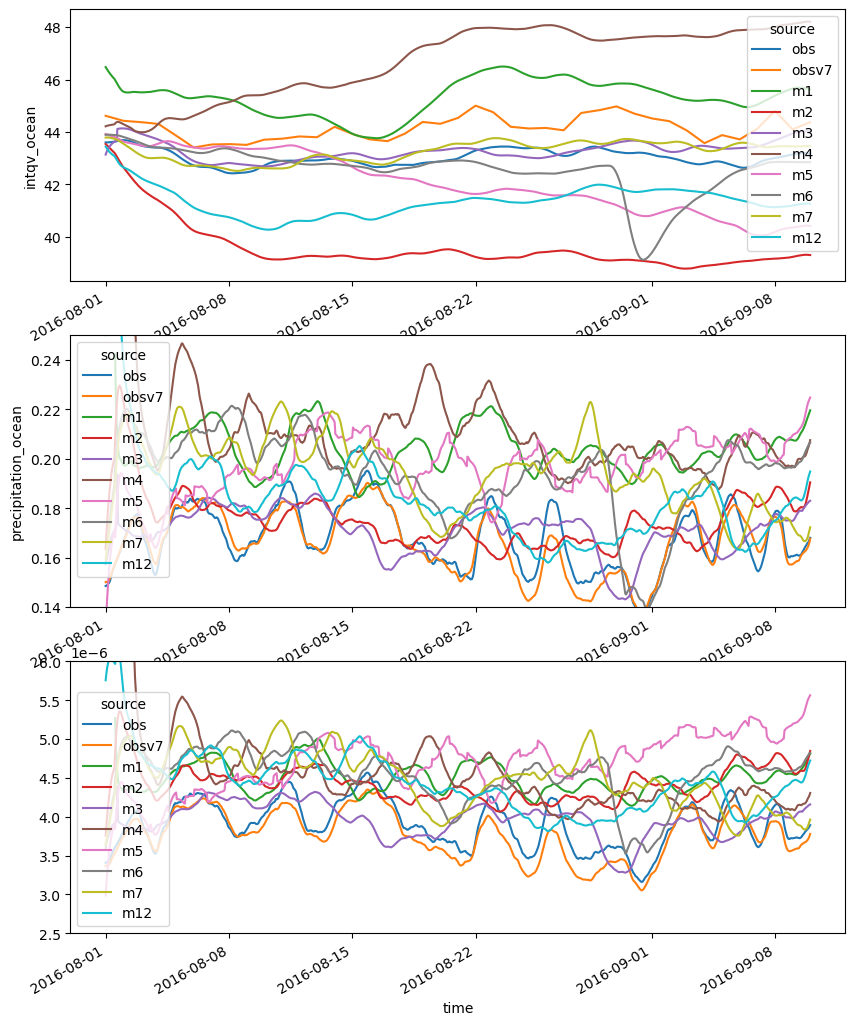

In [19]:
fig, axes = plt.subplots(3, 1, figsize=[10,12], dpi=100)
ax0 = axes[0]
xr.plot.line(ds.intqv_ocean, x='time', ax=ax0)
ax1 = axes[1]
xr.plot.line(ds.precipitation_ocean, x='time', ax=ax1)
ax1.set_ylim(0.14, 0.25)
ax2 = axes[2]
xr.plot.line(pcp_pwv_ocean, x='time', ax=ax2)
ax2.set_ylim(0.25e-5, 0.6e-5)

In [20]:
# Calculate mean values after the specific block out period
pwv_avg = dse_s.intqv.where(dse_s.time > max(block_times)).mean(dim='time')
pcp_avg = (dsr_s.precipitation*24).where(dsr_s.time > max(block_times)).mean(dim='time')
pcp_pwv_avg = pcp_pwv.where(ds.time > max(block_times)).mean(dim='time')

# Calculate relative difference in % with OBS
pwv_diff = 100 * (pwv_avg.isel(source=pwv_avg['source'] != 'obs') - pwv_avg.sel(source='obs')) / pwv_avg.sel(source='obs')
pcp_diff = 100 * (pcp_avg.isel(source=pcp_avg['source'] != 'obs') - pcp_avg.sel(source='obs')) / pcp_avg.sel(source='obs')
pcp_pwv_diff = 100 * (pcp_pwv_avg.isel(source=pcp_pwv_avg['source'] != 'obs') - pcp_pwv_avg.sel(source='obs')) / pcp_pwv_avg.sel(source='obs')

In [21]:
# Calculate mean values after the specific block out period
pwv_avg_ocean = ds.intqv_ocean.where(ds.time > max(block_times)).mean(dim='time')
pcp_avg_ocean = (dsr_s.precipitation_ocean*24).where(ds.time > max(block_times)).mean(dim='time')
pcp_pwv_avg_ocean = pcp_pwv_ocean.where(ds.time > max(block_times)).mean(dim='time')

# Calculate relative difference in % with OBS
pwv_diff_ocean = 100 * (pwv_avg_ocean.isel(source=pwv_avg_ocean['source'] != 'obs') - pwv_avg_ocean.sel(source='obs')) / pwv_avg_ocean.sel(source='obs')
pcp_diff_ocean = 100 * (pcp_avg_ocean.isel(source=pcp_avg_ocean['source'] != 'obs') - pcp_avg_ocean.sel(source='obs')) / pcp_avg_ocean.sel(source='obs')
pcp_pwv_diff_ocean = 100 * (pcp_pwv_avg_ocean.isel(source=pcp_pwv_avg_ocean['source'] != 'obs') - pcp_pwv_avg_ocean.sel(source='obs')) / pcp_pwv_avg_ocean.sel(source='obs')

## Function to plot time series

In [22]:
def plot_time_nrow(nrow, time_data, data_arr, titles, xlabels, ylabels, legends, figname,  
                    map_extent=None, lonbox=None, latbox=None, inset_param=None, map_panel=[0,0],
                    xscale=None, yscale=None, xlims=None, ylims=None, block_times=None, wspace=None, hspace=None,
                    legend_prop=None, fontsize=None, figsize=[10,10]):

    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'
    # fig, axes = plt.subplots(nrows=nrow, ncols=1, figsize=figsize, dpi=100)
    fig = plt.figure(figsize=figsize, dpi=100)
    gs = gridspec.GridSpec(nrow, 1)
    gs.update(wspace=wspace, hspace=hspace)

    lw = 1.2
    lcolors = {
        'obs':'k', 
        'obsv7': 'darkgray',
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'green',
        'm5': 'turquoise',
        'm6': 'lime',
        'm7': 'blue',
        'm8': 'deepskyblue',
        'm9': 'purple',
        'm10': 'violet',
        'm11': 'deeppink',
        'm12': 'dodgerblue',
    }
    time_fmt = mdates.DateFormatter('%m/%d')

    for row in range(0, nrow):
        # ax = axes[row]
        ax = plt.subplot(gs[row,0])
        source_list = list(data_arr[row].source.data)
        for ss in source_list:
            if ss == 'obs':
                linewidth = lw*4
            elif ss == 'obsv7':
                linewidth = lw*2
            else:
                lindwith = lw
            # linewidth = lw*3 if ss == 'obs' else lw
            ax.plot(time_data[row], data_arr[row].sel(source=ss), lcolors[ss], lw=linewidth, label=legends[row][ss])

        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
        ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
        ax.xaxis.set_major_formatter(time_fmt)
        ax.tick_params(axis='x', labelsize=None)
        ax.set_title(titles[row], loc='left')
        ax.set_ylabel(ylabels[row])
        ax.set_xlim(xlims[0], xlims[1])
        ax.set_ylim(ylims[row][0], ylims[row][1])
        ax.grid(which='major', ls='--')
        ax.legend(ncol=legend_prop['ncol'], fontsize=legend_prop['fontsize'], loc=legend_prop['loc'], bbox_to_anchor=legend_prop['anchor'])
        # Shade the period
        ax.axvspan(block_times[0], block_times[1], facecolor='silver', alpha=0.6, zorder=2)
        # for ii in range(len(monthday1)):
        #     ax.axvline(monthday1[ii], color='k', ls='--', lw=1.5)

    # fig.autofmt_xdate()
    # fig.tight_layout()
    fig.savefig(figname, bbox_inches='tight', dpi=300, facecolor='w')
    
    return fig

In [23]:
if PHASE == 'Summer':
    panel_numbers = ['(a)', '(c)', '(e)']
elif PHASE == 'Winter':
    panel_numbers = ['(b)', '(d)', '(f)']
print(panel_numbers)

# Make lat bound formats for plotting
lat_min = f'{-1*lat_bounds[0]}°S' if lat_bounds[0] < 0 else f'{lat_bounds[0]}°N'
lat_max = f'{-1*lat_bounds[1]}°S' if lat_bounds[1] < 0 else f'{lat_bounds[1]}°N'
print(lat_min, lat_max)

['(a)', '(c)', '(e)']
15°S 30°N


In [24]:
# Modify obs dictionary names for ocean
pwv_names = copy.deepcopy(name_map)
pwv_names['obs'] = 'ERA5'
pwv_names['obsv7'] = 'SSM/I'
# pwv_names

pcp_names = copy.deepcopy(name_map)
pcp_names['obs'] = 'IMERGv6'
pcp_names['obsv7'] = 'IMERGv7'
# pcp_names

pwv_pcp_names = copy.deepcopy(name_map)
pwv_pcp_names['obs'] = 'OBS-ERA5'
pwv_pcp_names['obsv7'] = 'OBS-SSM/I'
# pwv_pcp_names

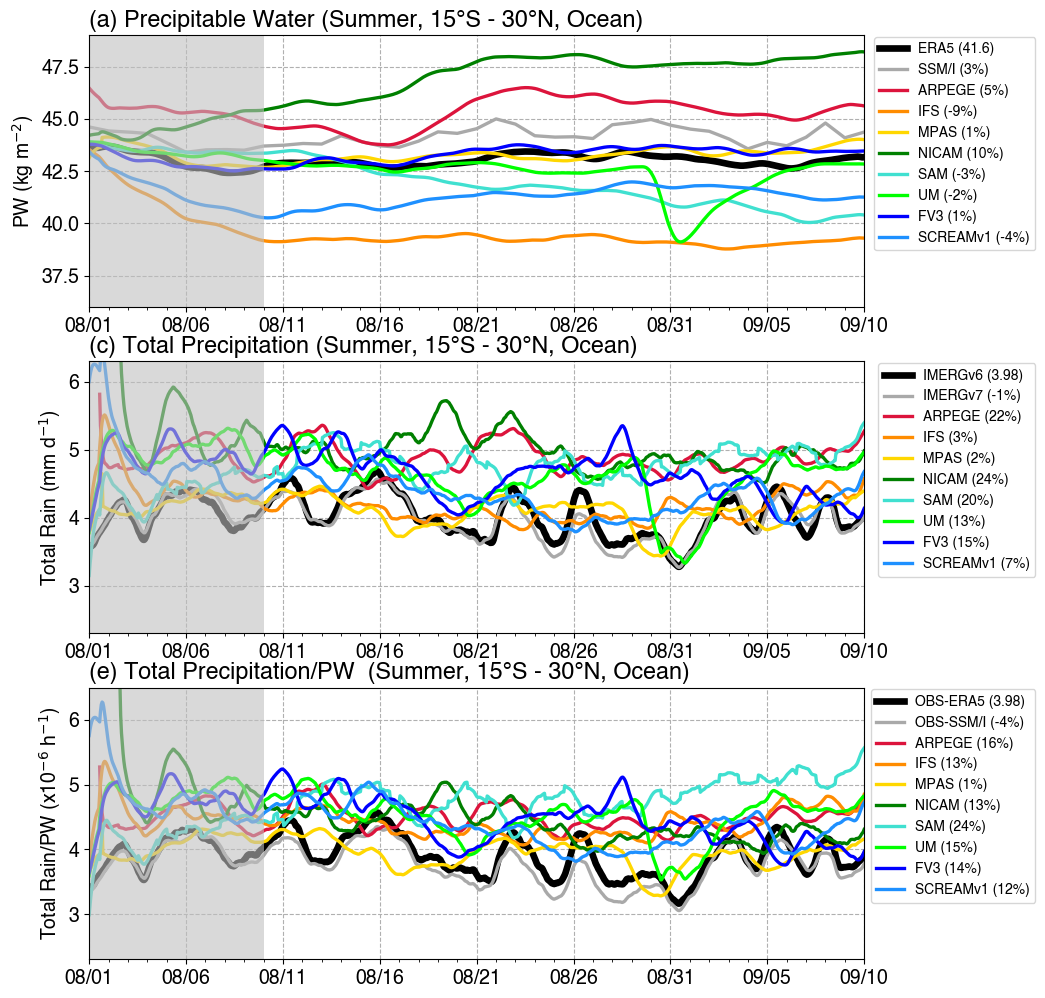

In [25]:
power = 6
scale = 10**(power)
data_arr = [ds.intqv_ocean, ds.precipitation_ocean*24, pcp_pwv_ocean*scale]
time_data = [ds.time, ds.time, ds.time]

titles = [
    f'{panel_numbers[0]} Precipitable Water ({PHASE}, {lat_min} - {lat_max}, Ocean)', 
    f'{panel_numbers[1]} Total Precipitation ({PHASE}, {lat_min} - {lat_max}, Ocean)', 
    f'{panel_numbers[2]} Total Precipitation/PW  ({PHASE}, {lat_min} - {lat_max}, Ocean)'
]
ylabels = ['PW (kg m$^{-2}$)', 'Total Rain (mm d$^{-1}$)', 'Total Rain/PW (x10$^{-6}$ h$^{-1}$)']
xlabels = 'Date'
xlims = [ds.time.min().data, ds.time.max().data]
ylims = [(36,49), (2.3,6.3), (2.3,6.5)]
# Add average values to legend
legends_pwv = {}
legends_pcp = {}
legends_pcppwv = {}
for key in name_map:
    if key == 'obs':
        legends_pwv[key] = f'{pwv_names[key]} ({pwv_avg.sel(source=key).values:.01f})'
        legends_pcp[key] = f'{pcp_names[key]} ({pcp_avg.sel(source=key).values:.02f})'
        legends_pcppwv[key] = f'{pwv_pcp_names[key]} ({pcp_pwv_avg.sel(source=key).values*scale:.02f})'
    else:
        legends_pwv[key] = f'{pwv_names[key]} ({pwv_diff_ocean.sel(source=key).values:.0f}%)'
        legends_pcp[key] = f'{pcp_names[key]} ({pcp_diff_ocean.sel(source=key).values:.0f}%)'
        legends_pcppwv[key] = f'{pwv_pcp_names[key]} ({pcp_pwv_diff_ocean.sel(source=key).values:.0f}%)'
legends = [legends_pwv, legends_pcp, legends_pcppwv]
# legend_prop = {'ncol':int(len(name_map)/2+1), 'fontsize':10, 'loc':'best'}
legend_prop = {'ncol':1, 'fontsize':10, 'loc':'upper right', 'anchor':(1.23, 1.02)}
figname = f'{figdir}globalmean_timeseries_pwv_total_rain_nodiurnal_ocean.png'
fig = plot_time_nrow(3, time_data, data_arr, titles, xlabels, ylabels, legends, figname,
                   xlims=xlims, ylims=ylims, block_times=block_times,
                   legend_prop=legend_prop, fontsize=14, figsize=[10,12])

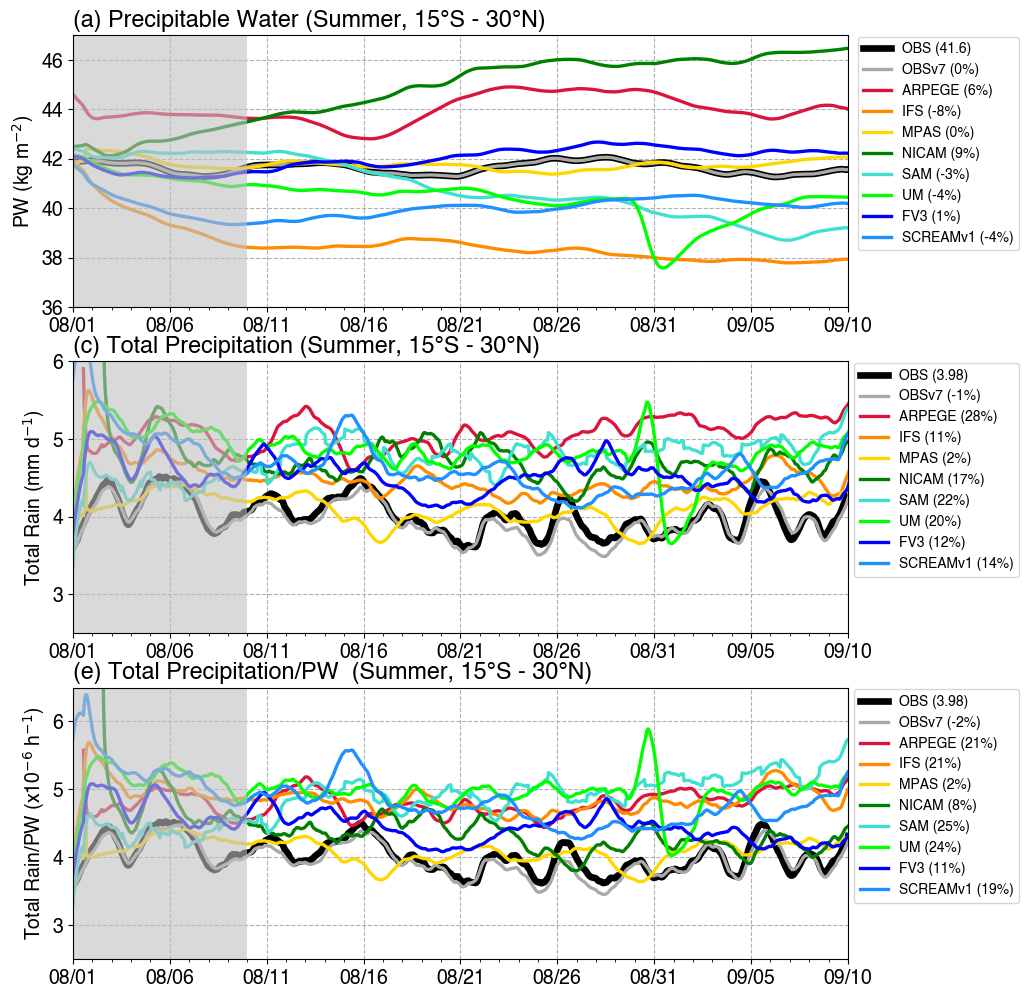

In [26]:
power = 6
scale = 10**(power)
data_arr = [dse_s.intqv, dsr_s.precipitation*24, pcp_pwv*scale]
time_data = [dse_s.time, dsr_s.time, ds.time]

titles = [
    f'{panel_numbers[0]} Precipitable Water ({PHASE}, {lat_min} - {lat_max})', 
    f'{panel_numbers[1]} Total Precipitation ({PHASE}, {lat_min} - {lat_max})', 
    f'{panel_numbers[2]} Total Precipitation/PW  ({PHASE}, {lat_min} - {lat_max})'
]
ylabels = ['PW (kg m$^{-2}$)', 'Total Rain (mm d$^{-1}$)', 'Total Rain/PW (x10$^{-6}$ h$^{-1}$)']
xlabels = 'Date'
xlims = [dse.time.min().data, dse.time.max().data]
ylims = [(36,47), (2.5,6), (2.5,6.5)]
# Add average values to legend
legends_pwv = {}
legends_pcp = {}
legends_pcppwv = {}
for key in name_map:
    if key == 'obs':
        legends_pwv[key] = f'{name_map[key]} ({pwv_avg.sel(source=key).values:.01f})'
        legends_pcp[key] = f'{name_map[key]} ({pcp_avg.sel(source=key).values:.02f})'
        legends_pcppwv[key] = f'{name_map[key]} ({pcp_pwv_avg.sel(source=key).values*scale:.02f})'
    else:
        legends_pwv[key] = f'{name_map[key]} ({pwv_diff.sel(source=key).values:.0f}%)'
        legends_pcp[key] = f'{name_map[key]} ({pcp_diff.sel(source=key).values:.0f}%)'
        legends_pcppwv[key] = f'{name_map[key]} ({pcp_pwv_diff.sel(source=key).values:.0f}%)'
legends = [legends_pwv, legends_pcp, legends_pcppwv]
# legend_prop = {'ncol':int(len(name_map)/2+1), 'fontsize':10, 'loc':'best'}
legend_prop = {'ncol':1, 'fontsize':10, 'loc':'upper right', 'anchor':(1.23, 1.02)}
figname = f'{figdir}globalmean_timeseries_pwv_total_rain_nodiurnal.png'
fig = plot_time_nrow(3, time_data, data_arr, titles, xlabels, ylabels, legends, figname,
                   xlims=xlims, ylims=ylims, block_times=block_times,
                   legend_prop=legend_prop, fontsize=14, figsize=[10,12])

In [27]:
# data_arr = [dse.intqv, dsr.precipitation*24]
# time_data = [dse.time, dsr.time]

# titles = [f'(a) Precipitable Water Vapor ({PHASE}, {lat_min} - {lat_max})', f'(b) Total Precipitation ({PHASE}, {lat_min} - {lat_max})', ]
# ylabels = ['PW (kg m$^{-2}$)', 'Total Rain (mm d$^{-1}$)',]
# xlabels = 'Date'
# xlims = [dse.time.min().data, dse.time.max().data]
# ylims = [(36,47), (2.5,6.5),]
# legends = [name_map, name_map]
# # legend_prop = {'ncol':int(len(name_map)/2)+1, 'fontsize':10, 'loc':'best', 'anchor':None}
# legend_prop = {'ncol':1, 'fontsize':10, 'loc':'upper right', 'anchor':(1.2, 1.02)}
# inset_param = {'width':'55%', 'height':'15%', 'loc':'lower left', 'borderpad':0.1}
# figname = f'{figdir}globalmean_timeseries_pwv_total_rain.png'
# fig = plot_time_nrow(2, time_data, data_arr, titles, xlabels, ylabels, legends, figname,
#                    xlims=xlims, ylims=ylims, block_times=block_times,
#                    legend_prop=legend_prop, fontsize=14, figsize=[10,8])

In [28]:
figdir

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/MCSMIP/'

# Resample the DataSet to daily frequency and calculate the mean

In [29]:
ds_daily = ds.resample(time='1D').mean(keep_attrs=True)

# Compute ratio of precipitation / PW
# units: (mm h^-1) / (kg m^-2) = 1e-3 m^3 kg^-1 h^-1
# ratio x density of water / 1e3 = 1e3 kg m^-3 * 1e-3 m^3 kg^-1 h^-1 / 1e3 = h^-1
pcp_pwv_daily = 1e-3 * ds_daily.precipitation / ds_daily.intqv

pcp_pwv_daily_ocean = 1e-3 * ds_daily.precipitation_ocean / ds_daily.intqv_ocean

ds_daily

/global/common/software/m1867/python/py310/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


<xarray.Dataset>
Dimensions:                 (source: 10, time: 41)
Coordinates:
  * source                  (source) <U5 'obs' 'obsv7' 'm1' ... 'm6' 'm7' 'm12'
  * time                    (time) datetime64[ns] 2016-08-01 ... 2016-09-10
Data variables:
    intqv                   (time, source) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    intqv_ocean             (time, source) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    precipitation           (time, source) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    precipitation_ocean     (time, source) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    mcs_precipitation       (time, source) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    mcs_precipitation_frac  (time, source) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    mcs_cloud_frac          (time, source) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    ccs_cloud_frac          (time, source) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes:
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    lon_bounds:  [-180  180]
    lat_bounds:  [-15  30]
    tracker:     PyFLEXTRKR

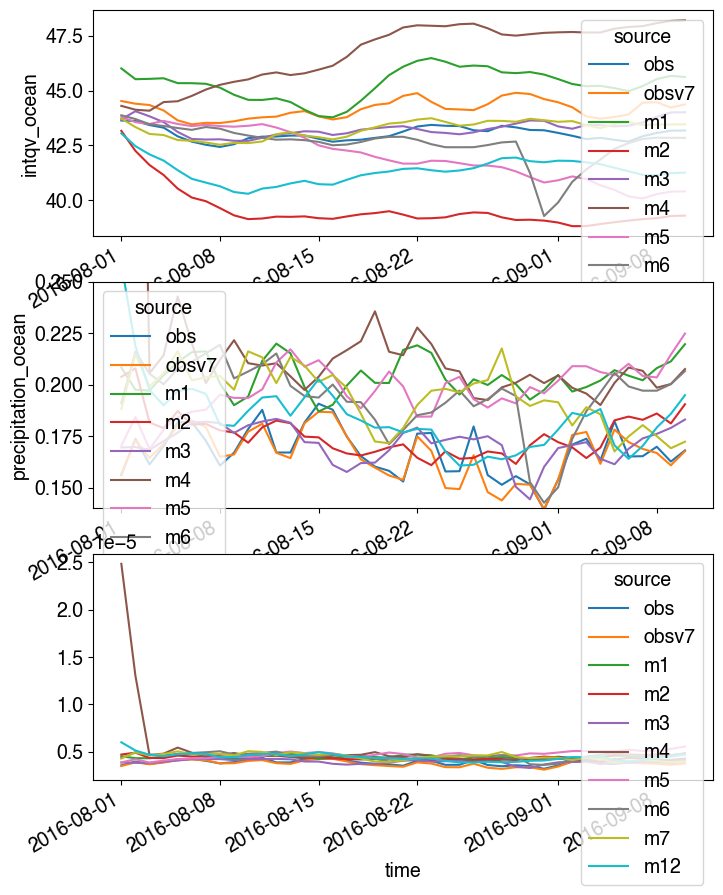

In [30]:
fig, axes = plt.subplots(3, 1, figsize=[8,10], dpi=100)
ax0 = axes[0]
xr.plot.line(ds_daily.intqv_ocean, x='time', ax=ax0)
ax1 = axes[1]
xr.plot.line(ds_daily.precipitation_ocean, x='time', ax=ax1)
ax1.set_ylim(0.14, 0.25)
ax2 = axes[2]
xr.plot.line(pcp_pwv_daily_ocean, x='time', ax=ax2)

In [31]:
def dataarray_to_dataframe(da, row_names=None, column_names=None):
    """
    Convert Xarray DataArray to Pandas DataFrame
    """
    # Convert to DataFrame
    df = pd.DataFrame(da.data)
    # Assign 'source' as column names
    if row_names:
        df.index = row_names
    if column_names:
        df.columns = column_names
    return df

In [32]:
name_map.values()

dict_values(['OBS', 'OBSv7', 'ARPEGE', 'IFS', 'MPAS', 'NICAM', 'SAM', 'UM', 'FV3', 'SCREAMv1'])

In [33]:
pd.to_datetime(block_times[1])

Timestamp('2016-08-10 00:00:00')

In [34]:
# Subset times after a specified date
da_tmp = ds_daily.intqv.where(ds_daily.time > pd.to_datetime(block_times[1]), drop=True)
# Convert to Pandas DataFrame
df_intqv = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = ds_daily.precipitation.where(ds_daily.time > pd.to_datetime(block_times[1]), drop=True)*24
df_precipitation = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = pcp_pwv_daily.where(ds_daily.time > pd.to_datetime(block_times[1]), drop=True)
df_pcp_pwv = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

# Calculate PW and precipitation mean and standard deviation
x_avg = ds_daily.intqv.where(ds_daily.time > pd.to_datetime(block_times[1]), drop=True).mean(dim='time', keep_attrs=True)
y_avg = ds_daily.precipitation.where(ds_daily.time > pd.to_datetime(block_times[1]), drop=True).mean(dim='time', keep_attrs=True)*24

x_std = ds_daily.intqv.where(ds_daily.time > pd.to_datetime(block_times[1]), drop=True).std(dim='time', keep_attrs=True)
y_std = ds_daily.precipitation.where(ds_daily.time > pd.to_datetime(block_times[1]), drop=True).std(dim='time', keep_attrs=True)*24

In [35]:
# Subset times after a specified date
da_tmp = ds_daily.intqv_ocean.where(ds_daily.time > pd.to_datetime(block_times[1]), drop=True)
# Convert to Pandas DataFrame
df_intqv_ocean = dataarray_to_dataframe(da_tmp, column_names=pwv_names.values())

da_tmp = ds_daily.precipitation_ocean.where(ds_daily.time > pd.to_datetime(block_times[1]), drop=True)*24
df_precipitation_ocean = dataarray_to_dataframe(da_tmp, column_names=pcp_names.values())

da_tmp = pcp_pwv_daily_ocean.where(ds_daily.time > pd.to_datetime(block_times[1]), drop=True)
df_pcp_pwv_ocean = dataarray_to_dataframe(da_tmp, column_names=pwv_pcp_names.values())

# Calculate PW and precipitation mean and standard deviation
x_avg_ocean = ds_daily.intqv_ocean.where(ds_daily.time > pd.to_datetime(block_times[1]), drop=True).mean(dim='time', keep_attrs=True)
y_avg_ocean = ds_daily.precipitation_ocean.where(ds_daily.time > pd.to_datetime(block_times[1]), drop=True).mean(dim='time', keep_attrs=True)*24

x_std_ocean = ds_daily.intqv_ocean.where(ds_daily.time > pd.to_datetime(block_times[1]), drop=True).std(dim='time', keep_attrs=True)
y_std_ocean = ds_daily.precipitation_ocean.where(ds_daily.time > pd.to_datetime(block_times[1]), drop=True).std(dim='time', keep_attrs=True)*24

## Make fit lines for OBS precipitation vs. PW

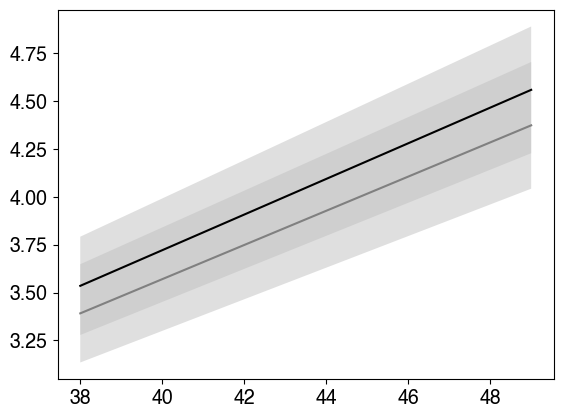

In [36]:
slope_ocean_obs = (y_avg_ocean.sel(source='obs') / x_avg_ocean.sel(source='obs')).values
slope_ocean_obsv7 = (y_avg_ocean.sel(source='obsv7') / x_avg_ocean.sel(source='obsv7')).values

slope_ocean_hi_obs = ((y_avg_ocean.sel(source='obs') + y_std_ocean.sel(source='obs')) / x_avg_ocean.sel(source='obs')).values
slope_ocean_lo_obs = ((y_avg_ocean.sel(source='obs') - y_std_ocean.sel(source='obs')) / x_avg_ocean.sel(source='obs')).values

slope_ocean_hi_obsv7 = ((y_avg_ocean.sel(source='obsv7') + y_std_ocean.sel(source='obsv7')) / x_avg_ocean.sel(source='obsv7')).values
slope_ocean_lo_obsv7 = ((y_avg_ocean.sel(source='obsv7') - y_std_ocean.sel(source='obsv7')) / x_avg_ocean.sel(source='obsv7')).values

xfit = np.linspace(38, 49, 1000)
yfit_ocean_obs = xfit * slope_ocean_obs
yfit_ocean_obsv7 = xfit * slope_ocean_obsv7
yfit_ocean_hi_obs = xfit * slope_ocean_hi_obs
yfit_ocean_lo_obs = xfit * slope_ocean_lo_obs
yfit_ocean_hi_obsv7 = xfit * slope_ocean_hi_obsv7
yfit_ocean_lo_obsv7 = xfit * slope_ocean_lo_obsv7
plt.plot(xfit, yfit_ocean_obs, color='k')
plt.plot(xfit, yfit_ocean_obsv7, color='gray')
plt.fill_between(xfit, yfit_ocean_lo_obs, yfit_ocean_hi_obs, facecolor='silver', alpha=0.5)
plt.fill_between(xfit, yfit_ocean_lo_obsv7, yfit_ocean_hi_obsv7, facecolor='silver', alpha=0.5)

In [37]:
# slope_ocean_obs = pcp_pwv_avg_ocean.sel(source='obs').values * 1e3
# slope_ocean_obs7 = pcp_pwv_avg_ocean.sel(source='obsv7').values * 1e3
# xfit = np.linspace(0, 50, 1000)
# yfit_ocean_obs = xfit * slope_ocean_obs
# yfit_ocean_obs7 = xfit * slope_ocean_obs7
# plt.plot(xfit, yfit_ocean_obs)
# plt.plot(xfit, yfit_ocean_obs7)

In [38]:
if PHASE == 'Summer':
    panel_numbers = ['(a)', '(c)', '(e)']
    legend_loc = 'upper right'
elif PHASE == 'Winter':
    panel_numbers = ['(b)', '(d)', '(f)']
    legend_loc = 'lower left'
print(panel_numbers)

['(a)', '(c)', '(e)']


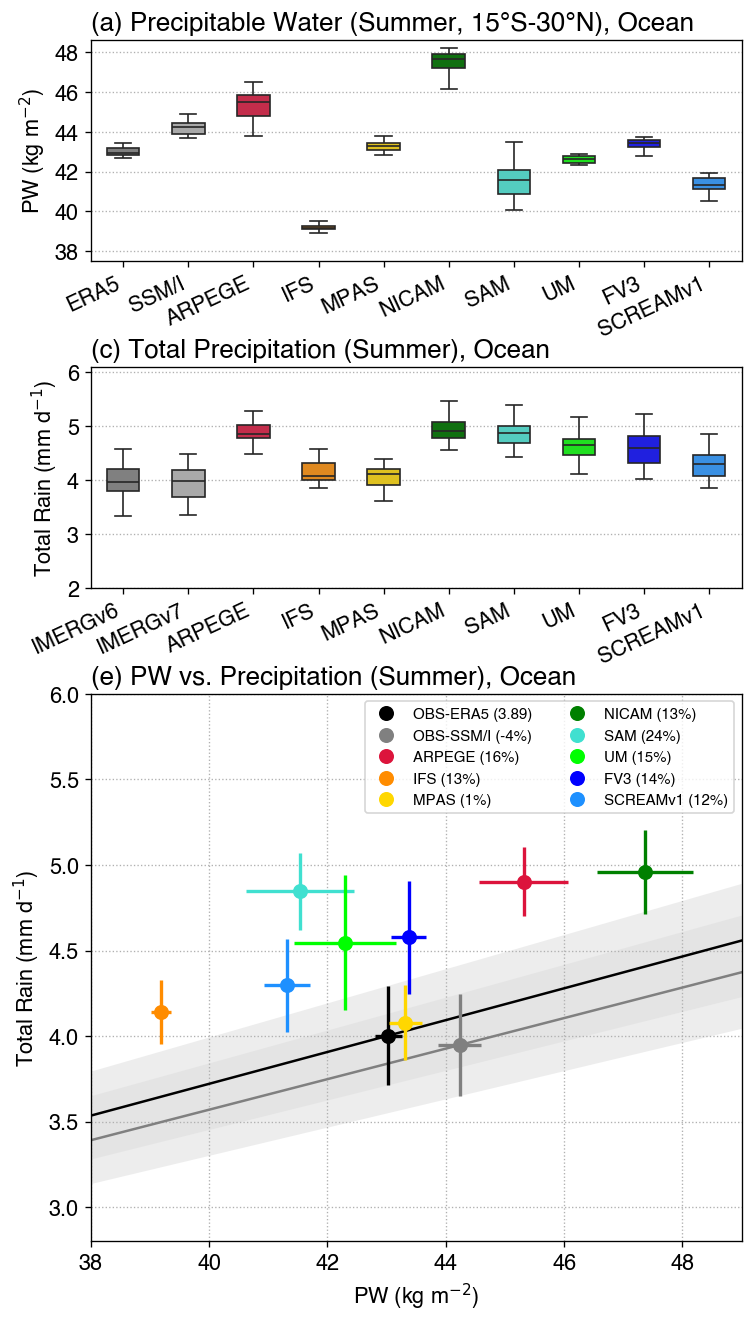

In [39]:
mpl.rcParams['font.size'] = 13
mpl.rcParams['font.family'] = 'Helvetica'

fig = plt.figure(figsize=(7,13), dpi=120)
gs = gridspec.GridSpec(4, 1, wspace=0.25, hspace=0.48)

lw = 1.
fcolors = {
    'obs': 'gray', 
    'obsv7': 'darkgray',
    'm1': 'crimson',
    'm2': 'darkorange', 
    'm3': 'gold',
    'm4': 'green',
    'm5': 'turquoise',
    'm6': 'lime',
    'm7': 'blue',
    'm8': 'deepskyblue',
    'm9': 'purple',
    'm10': 'violet',
    'm11': 'deeppink',
    'm12': 'dodgerblue',
}
fcolors_list = []
for key in name_map:
    fcolors_list.append(fcolors[key])
lcolors = fcolors
lcolors['obs'] = 'k'
lcolors['obsv7'] = 'gray'
boxprops = {'linewidth':0.8}
flierprops = {'linewidth':0.8}
boxwidth = 0.5
rotation = 25
fillcolor = 'gainsboro'

# Add average values to legend
legends_pcppwv = {}
for key in name_map:
    if key == 'obs':
        legends_pcppwv[key] = f'{pwv_pcp_names[key]} ({pcp_pwv_avg_ocean.sel(source=key).values*scale:.02f})'
    else:
        legends_pcppwv[key] = f'{pwv_pcp_names[key]} ({pcp_pwv_diff_ocean.sel(source=key).values:.0f}%)'
# legend_prop = {'ncol':1, 'fontsize':10, 'loc':'upper right', 'anchor':(1.43, 1.02)}
legend_prop = {'ncol':2, 'fontsize':9, 'loc':legend_loc}

ax1 = fig.add_subplot(gs[0, 0])
sns.boxplot(data=df_intqv_ocean, orient='v', showfliers=False, ax=ax1, palette=fcolors_list, linewidth=lw, width=boxwidth)
ax1.grid(ls=':', axis='y')
ax1.set_ylabel('PW (kg m$^{-2}$)')
ax1.set_title(f'{panel_numbers[0]} Precipitable Water ({PHASE}, {lat_min}-{lat_max}), Ocean', loc='left')
ax1.set_ylim(37.5,48.6)
ax1.set_yticks(np.arange(38,49.1,2))
plt.xticks(rotation=rotation, ha='right')

ax2 = fig.add_subplot(gs[1, 0])
sns.boxplot(data=df_precipitation_ocean, orient='v', showfliers=False, ax=ax2, palette=fcolors_list, linewidth=lw, width=boxwidth)
ax2.set_ylabel('Total Rain (mm d$^{-1}$)')
ax2.grid(ls=':', axis='y')
ax2.set_title(f'{panel_numbers[1]} Total Precipitation ({PHASE}), Ocean', loc='left')
ax2.set_ylim(2.,6.1)
plt.xticks(rotation=rotation, ha='right')

ax3 = fig.add_subplot(gs[2:, 0])
for ii, isrc in enumerate(x_avg.source.data):
    ax3.errorbar(x_avg_ocean.sel(source=isrc), y_avg_ocean.sel(source=isrc), xerr=x_std_ocean.sel(source=isrc), yerr=y_std_ocean.sel(source=isrc), color=lcolors[isrc], lw=lw*2, zorder=3)
    ax3.plot(x_avg_ocean.sel(source=isrc), y_avg_ocean.sel(source=isrc), 'o', color=lcolors[isrc], markersize=8, label=legends_pcppwv[isrc], zorder=3)
# Plot fit lines
fillcolor = 'gainsboro'
ax3.plot(xfit, yfit_ocean_obs, color=fcolors['obs'], zorder=2)
ax3.plot(xfit, yfit_ocean_obsv7, color=fcolors['obsv7'], zorder=2)
ax3.fill_between(xfit, yfit_ocean_lo_obs, yfit_ocean_hi_obs, facecolor=fillcolor, alpha=0.5, zorder=1)
ax3.fill_between(xfit, yfit_ocean_lo_obsv7, yfit_ocean_hi_obsv7, facecolor=fillcolor, alpha=0.5, zorder=1)
ax3.set_xlabel('PW (kg m$^{-2}$)')
ax3.set_ylabel('Total Rain (mm d$^{-1}$)')
ax3.set_title(f'{panel_numbers[2]} PW vs. Precipitation ({PHASE}), Ocean', loc='left')
ax3.grid(ls=':')
ax3.set_ylim(2.8, 6.0)
ax3.set_xlim(min(xfit), max(xfit))
ax3.legend(ncol=legend_prop['ncol'], fontsize=legend_prop['fontsize'], loc=legend_prop['loc'], )
# Find ranges between OBS
x_ranges = np.array([
    (x_avg_ocean - x_std_ocean).sel(source='obs').values,
    (x_avg_ocean + x_std_ocean).sel(source='obs').values,
    (x_avg_ocean - x_std_ocean).sel(source='obsv7').values,
    (x_avg_ocean + x_std_ocean).sel(source='obsv7').values,
])
y_ranges = np.array([
    (y_avg_ocean - y_std_ocean).sel(source='obs').values,
    (y_avg_ocean + y_std_ocean).sel(source='obs').values,
    (y_avg_ocean - y_std_ocean).sel(source='obsv7').values,
    (y_avg_ocean + y_std_ocean).sel(source='obsv7').values,
])
# Fill between OBS ranges
# ax3.axvspan(np.min(x_ranges), np.max(x_ranges), facecolor=fillcolor)
# ax3.axhspan(np.min(y_ranges), np.max(y_ranges), facecolor=fillcolor)

# figname = f'{figdir}globalmean_pwv_totalrain_daily_boxplot_scatterplot_ocean.png'
figname = f'{figdir}globalmean_pwv_totalrain_daily_boxplot_scatterplot_ocean.pdf'
fig.savefig(figname, bbox_inches='tight', dpi=300, facecolor='w')

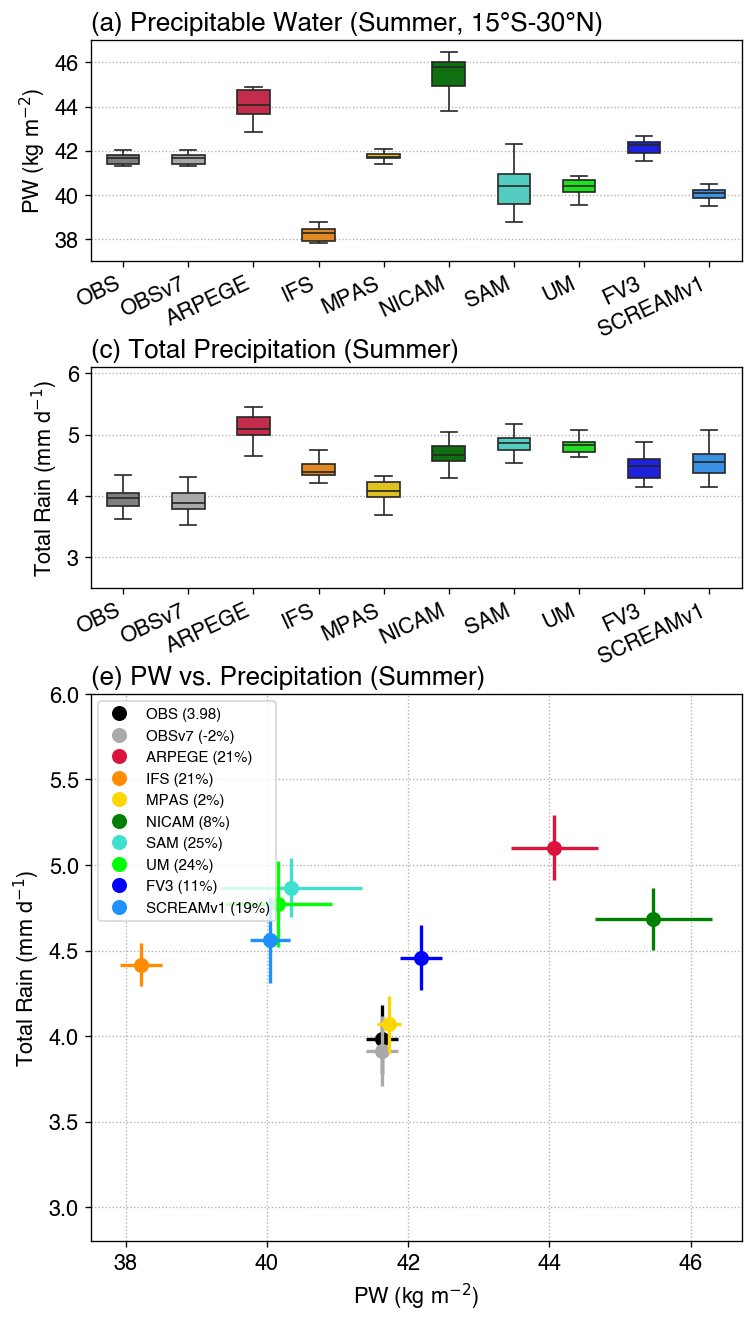

In [40]:
mpl.rcParams['font.size'] = 13
mpl.rcParams['font.family'] = 'Helvetica'

fig = plt.figure(figsize=(7,13), dpi=120)
gs = gridspec.GridSpec(4, 1, wspace=0.25, hspace=0.48)

lw = 1.
fcolors = {
    'obs': 'gray', 
    'obsv7': 'darkgray',
    'm1': 'crimson',
    'm2': 'darkorange', 
    'm3': 'gold',
    'm4': 'green',
    'm5': 'turquoise',
    'm6': 'lime',
    'm7': 'blue',
    'm8': 'deepskyblue',
    'm9': 'purple',
    'm10': 'violet',
    'm11': 'deeppink',
    'm12': 'dodgerblue',
}
fcolors_list = []
for key in name_map:
    fcolors_list.append(fcolors[key])
lcolors = fcolors
lcolors['obs'] = 'k'
boxprops = {'linewidth':0.8}
flierprops = {'linewidth':0.8}
boxwidth = 0.5
rotation = 25

# Add average values to legend
legends_pcppwv = {}
for key in name_map:
    if key == 'obs':
        legends_pcppwv[key] = f'{name_map[key]} ({pcp_pwv_avg.sel(source=key).values*scale:.02f})'
    else:
        legends_pcppwv[key] = f'{name_map[key]} ({pcp_pwv_diff.sel(source=key).values:.0f}%)'
# legend_prop = {'ncol':1, 'fontsize':10, 'loc':'upper right', 'anchor':(1.43, 1.02)}
legend_prop = {'ncol':1, 'fontsize':9, 'loc':'best'}

ax1 = fig.add_subplot(gs[0, 0])
sns.boxplot(data=df_intqv, orient='v', showfliers=False, ax=ax1, palette=fcolors_list, linewidth=lw, width=boxwidth)
ax1.grid(ls=':', axis='y')
ax1.set_ylabel('PW (kg m$^{-2}$)')
ax1.set_title(f'{panel_numbers[0]} Precipitable Water ({PHASE}, {lat_min}-{lat_max})', loc='left')
ax1.set_ylim(37,47)
plt.xticks(rotation=rotation, ha='right')

ax2 = fig.add_subplot(gs[1, 0])
sns.boxplot(data=df_precipitation, orient='v', showfliers=False, ax=ax2, palette=fcolors_list, linewidth=lw, width=boxwidth)
ax2.set_ylabel('Total Rain (mm d$^{-1}$)')
ax2.grid(ls=':', axis='y')
ax2.set_title(f'{panel_numbers[1]} Total Precipitation ({PHASE})', loc='left')
ax2.set_ylim(2.5,6.1)
plt.xticks(rotation=rotation, ha='right')

ax3 = fig.add_subplot(gs[2:, 0])
for ii, isrc in enumerate(x_avg.source.data):
    ax3.errorbar(x_avg.sel(source=isrc), y_avg.sel(source=isrc), xerr=x_std.sel(source=isrc), yerr=y_std.sel(source=isrc), color=lcolors[isrc], lw=lw*2)
    ax3.plot(x_avg.sel(source=isrc), y_avg.sel(source=isrc), 'o', color=lcolors[isrc], markersize=8, label=legends_pcppwv[isrc])
ax3.set_xlabel('PW (kg m$^{-2}$)')
ax3.set_ylabel('Total Rain (mm d$^{-1}$)')
ax3.set_title(f'{panel_numbers[2]} PW vs. Precipitation ({PHASE})', loc='left')
ax3.grid(ls=':')
ax3.set_ylim(2.8,6.0)
# ax3.legend(ncol=legend_prop['ncol'], fontsize=legend_prop['fontsize'], loc=legend_prop['loc'], bbox_to_anchor=legend_prop['anchor'])
ax3.legend(ncol=legend_prop['ncol'], fontsize=legend_prop['fontsize'], loc=legend_prop['loc'], )

figname = f'{figdir}globalmean_pwv_totalrain_daily_boxplot_scatterplot.png'
fig.savefig(figname, bbox_inches='tight', dpi=300, facecolor='w')

In [41]:
# if PHASE == 'Summer':
#     panel_numbers = ['(a)', '(b)', '(c)']
# elif PHASE == 'Winter':
#     panel_numbers = ['(d)', '(e)', '(f)']
# print(panel_numbers)

In [42]:
# mpl.rcParams['font.size'] = 12
# mpl.rcParams['font.family'] = 'Helvetica'

# fig = plt.figure(figsize=(13,7), dpi=120)
# gs = gridspec.GridSpec(2, 2, wspace=0.25, hspace=0.45)

# lw = 1.
# fcolors = {
#     'obs': 'darkgray', 
#     'obsv7': 'lightgray',
#     'm1': 'crimson',
#     'm2': 'darkorange', 
#     'm3': 'gold',
#     'm4': 'green',
#     'm5': 'turquoise',
#     'm6': 'lime',
#     'm7': 'blue',
#     'm8': 'deepskyblue',
#     'm9': 'purple',
#     'm10': 'violet',
#     'm11': 'deeppink',
#     'm12': 'dodgerblue',
# }
# fcolors_list = list(fcolors.values())
# lcolors = fcolors
# lcolors['obs'] = 'k'
# boxprops = {'linewidth':0.8}
# flierprops = {'linewidth':0.8}
# boxwidth = 0.5

# # Add average values to legend
# legends_pcppwv = {}
# for key in name_map:
#     if key == 'obs':
#         legends_pcppwv[key] = f'{name_map[key]} ({pcp_pwv_avg.sel(source=key).values*scale:.02f})'
#     else:
#         legends_pcppwv[key] = f'{name_map[key]} ({pcp_pwv_diff.sel(source=key).values:.0f}%)'
# legend_prop = {'ncol':1, 'fontsize':10, 'loc':'upper right', 'anchor':(1.43, 1.02)}

# ax1 = fig.add_subplot(gs[0, 0])
# sns.boxplot(data=df_intqv, orient='v', showfliers=False, ax=ax1, palette=fcolors_list, linewidth=lw, width=boxwidth)
# ax1.grid(ls=':', axis='y')
# ax1.set_ylabel('PW (kg m$^{-2}$)')
# ax1.set_title(f'{panel_numbers[0]} Precipitable Water Vapor ({PHASE})', loc='left')
# ax1.set_ylim(37,47)
# plt.xticks(rotation=30, ha='right')

# ax2 = fig.add_subplot(gs[1, 0])
# sns.boxplot(data=df_precipitation, orient='v', showfliers=False, ax=ax2, palette=fcolors_list, linewidth=lw, width=boxwidth)
# ax2.set_ylabel('Total Rain (mm d$^{-1}$)')
# ax2.grid(ls=':', axis='y')
# ax2.set_title(f'{panel_numbers[1]} Total Precipitation ({PHASE})', loc='left')
# ax2.set_ylim(2.5,6.1)
# plt.xticks(rotation=30, ha='right')

# ax3 = fig.add_subplot(gs[:, 1])
# for ii, isrc in enumerate(x_avg.source.data):
#     ax3.errorbar(x_avg.sel(source=isrc), y_avg.sel(source=isrc), xerr=x_std.sel(source=isrc), yerr=y_std.sel(source=isrc), color=lcolors[isrc], lw=lw*2)
#     ax3.plot(x_avg.sel(source=isrc), y_avg.sel(source=isrc), 'o', color=lcolors[isrc], markersize=8, label=legends_pcppwv[isrc])
# ax3.set_xlabel('PW (kg m$^{-2}$)')
# ax3.set_ylabel('Total Rain (mm d$^{-1}$)')
# ax3.set_title(f'{panel_numbers[2]} PW vs. Precipitation ({PHASE}, {lat_min} - {lat_max})', loc='left')
# ax3.grid(ls=':')
# ax1.set_ylim(37,47)
# ax3.set_ylim(2.8,6.0)
# ax3.legend(ncol=legend_prop['ncol'], fontsize=legend_prop['fontsize'], loc=legend_prop['loc'], bbox_to_anchor=legend_prop['anchor'])

# figname = f'{figdir}globalmean_pwv_totalrain_daily_boxplot_scatterplot.png'
# fig.savefig(figname, bbox_inches='tight', dpi=300, facecolor='w')

In [43]:
figname

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/MCSMIP/globalmean_pwv_totalrain_daily_boxplot_scatterplot.png'